# Image classification tutorial with FastAI

## Gather and clean data

We'll use the Bing Image search API to collect images and then we'll clean the data

In [1]:
import os

# FastAI dependencies
from fastai.vision.all import *
from fastcore.foundation import *
from fastai.vision.widgets import *

In [2]:
key = os.environ.get('AZURE_SEARCH_KEY', '8e0b7844597d43f5b6058421fa6bb284')

In [3]:
# Taken from FastAI

def search_images_bing(key, term, min_sz=128, max_images=150):
    params = dict(q=term, count=max_images, min_height=min_sz, min_width=min_sz)
    search_url = "https://api.bing.microsoft.com/v7.0/images/search"
    response = requests.get(search_url, headers={"Ocp-Apim-Subscription-Key":key}, params=params)
    response.raise_for_status()
    return L(response.json()['value'])

In [4]:
# just to see the function
search_images_bing

<function __main__.search_images_bing(key, term, min_sz=128, max_images=150)>

In [5]:
# search the images with the specific term
results = search_images_bing(key, 'congo grey parrot', max_images=1)
ims = results.attrgot('contentUrl')
len(ims)

1

#### Verification

after downloading the URLs of 150 black cockatoos, it's a good idea to verify the pictures as there is no way to be sure exactly what images a search like this will find 

In [6]:
# let's look at one
ims[0]

'https://plumptonparkzoo.org/wp-content/uploads/2018/04/congo-african-grey-parrot.jpg'

In [7]:
dest = 'images/congo_grey_parrot.jpg'
download_url(ims[0], dest)

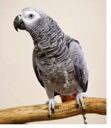

In [8]:
im = Image.open(dest)
im.to_thumb(128,128)

### Gather the different types of images

In [9]:
bird_types = 'cardinal', 'bald eagle', 'congo grey parrot'
path = Path('images/birds')

In [10]:
# create the folders if they do not exist
if not path.exists():
    path.mkdir()
    for o in bird_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bird')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [11]:
# get the path of the images
fns = get_image_files(path)
fns

(#414) [Path('images/birds/bald eagle/00000000.jpg'),Path('images/birds/bald eagle/00000001.jpg'),Path('images/birds/bald eagle/00000002.jpg'),Path('images/birds/bald eagle/00000003.jpg'),Path('images/birds/bald eagle/00000004.jpeg'),Path('images/birds/bald eagle/00000005.jpg'),Path('images/birds/bald eagle/00000006.jpg'),Path('images/birds/bald eagle/00000007.jpg'),Path('images/birds/bald eagle/00000008.jpg'),Path('images/birds/bald eagle/00000009.jpg')...]

In [12]:
# verify if the images are corrupt
failed = verify_images(fns)
failed

(#11) [Path('images/birds/bald eagle/00000055.JPG'),Path('images/birds/bald eagle/00000059.jpg'),Path('images/birds/bald eagle/00000074.jpg'),Path('images/birds/bald eagle/00000078.jpg'),Path('images/birds/bald eagle/00000088.jpg'),Path('images/birds/bald eagle/00000107.jpg'),Path('images/birds/bald eagle/00000109.jpg'),Path('images/birds/bald eagle/00000125.jpg'),Path('images/birds/bald eagle/00000129.jpg'),Path('images/birds/bald eagle/00000137.jpg')...]

In case that we had corrupt images, To remove all the failed images, you can use unlink on each of them. Note that, like most fastai functions that return a collection, verify_images returns an object of type L, which includes the map method. This calls the passed function on each element of the collection:

In [13]:
failed.map(Path.unlink);

## Creating a dataloader from the downloaded data

To turn our downloaded data into a DataLoaders object we need to tell fastai at least four things:

What kinds of data we are working with
How to get the list of items
How to label these items
How to create the validation set
So far we have seen a number of factory methods for particular combinations of these things, which are convenient when you have an application and data structure that happen to fit into those predefined methods. For when you don't, fastai has an extremely flexible system called the data block API. With this API you can fully customize every stage of the creation of your DataLoaders. Here is what we need to create a DataLoaders for the dataset that we just downloaded:

In [55]:
birds = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [56]:
# creating a DataBlock object
dls = birds.dataloaders(path)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


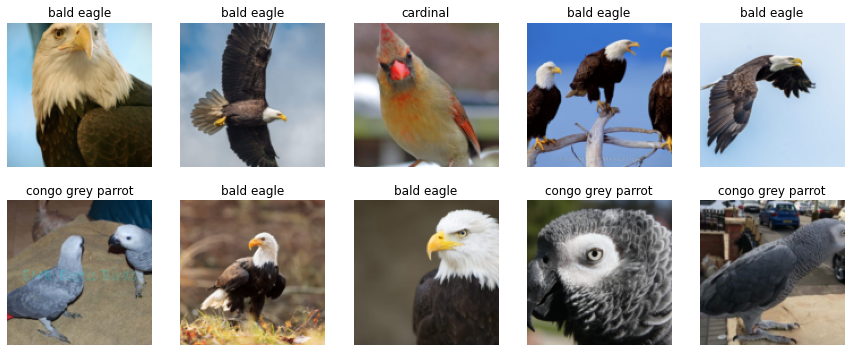

In [57]:
# visualise a small batch of the dataset
dls.valid.show_batch(max_n=10, nrows=2)

# Training the model, and using it to clean the data

Usually, in practice we randomly select part of the image, and crop to just that part. On each epoch (which is one complete pass through all of our images in the dataset) we randomly select a different part of each image. This means that our model can learn to focus on, and recognize, different features in our images. It also reflects how images work in the real world: different photos of the same thing may be framed in slightly different ways.

In [58]:
birds = birds.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()) # min scale determines how much of the image to select at minimum
dls = birds.dataloaders(path)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


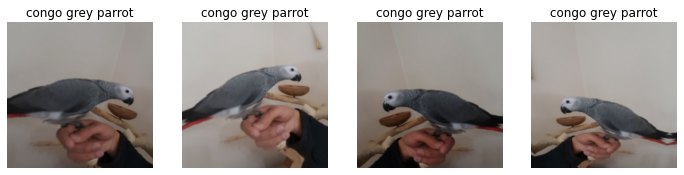

In [59]:
dls.train.show_batch(max_n=4, nrows=1, unique=True)

In [60]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.075979,0.043383,0.012658,00:14


epoch,train_loss,valid_loss,error_rate,time
0,0.098654,0.009594,0.000000,00:14
1,0.064997,0.000598,0.000000,00:14
2,0.044902,0.000366,0.000000,00:14
3,0.036485,0.000446,0.000000,00:14


We will use a confusion matrix to see the mistakes of the model, i.e. if the model predicted balck cockatoos as cockatiels

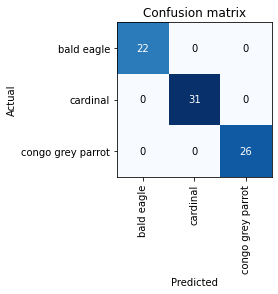

In [61]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

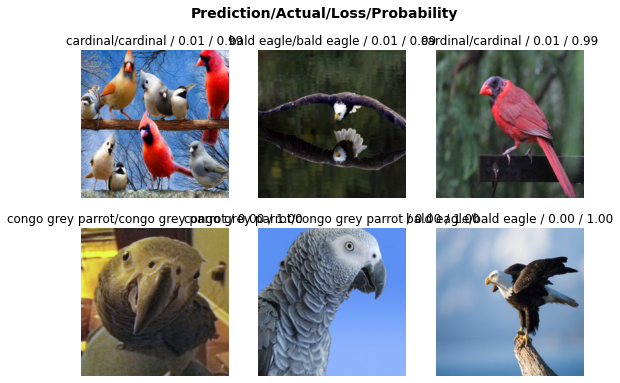

In [63]:
interp.plot_top_losses(6, nrows=2)

#### Let's use the handy FastAI GUI for data cleaning 

In [44]:
cleaner = ImageClassifierCleaner(learn)
cleaner

To delete (unlink) all images selected for deletion, we would run:

In [45]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

To move images for which we've selected a different category, we would run:

In [46]:
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Using the model for inference

In [64]:
learn.export()

In [65]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [66]:
learn_inf = load_learner(path/'export.pkl')

In [67]:
learn_inf.predict('images/cardinal.jpg')

('cardinal', tensor(1), tensor([1.3032e-05, 9.9986e-01, 1.2552e-04]))

In [68]:
# See the different classes and their order
learn_inf.dls.vocab

['bald eagle', 'cardinal', 'congo grey parrot']

# Using IPython widgets

In [69]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [74]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [75]:
# event handler for classification
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [76]:
VBox([widgets.Label('Select your bird!'), 
      btn_upload, btn_run, out_pl, lbl_pred])